In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

# Import training data

In [4]:
training_run_names = ["08_09_2019_run_01",
                      "08_13_2019_run_02",
                      "08_13_2019_run_03",
                      "08_15_2019_run_02",
                      "08_15_2019_run_03",
                      "08_16_2019_run_01",]

In [5]:
training_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in training_run_names)]

In [6]:
training_runs

,date,run_name,molbit_set,description,approx_runtime,approx_reads_per_min,read_count,lengths,DNAse,flowcell,...,basecalled_fast5_dir,passed_basecalling,passed_basecalling_pct,sw_scores_file,sw_labels,filtered_sw_labels,model_v4_0_1_all_preds,model_v4_0_1_labeled_preds,preprocessed_dataset_all,preprocessed_dataset_labeled
0,20190809.0,08_09_2019_run_01,0.0,training data,0:20,10000.0,"209,650",400,no,FAL16929,...,NaN,193498,92.295731,/disk1/pore_data/MinION_sequencing_data_201908...,NaN,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/ssd1/pore_data/v4_test/08_09_2019_run_01_all....,/ssd1/pore_data/v4_test/08_09_2019_run_01_only...
2,20190813.0,08_13_2019_run_02,1.0,training data,0:35,NaN,"304,000",400,no,FAL16929,...,NaN,279707,92.008882,/disk1/pore_data/MinION_sequencing_data_201908...,NaN,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/ssd1/pore_data/v4_test/08_13_2019_run_02_all....,/ssd1/pore_data/v4_test/08_13_2019_run_02_only...
3,20190813.0,08_13_2019_run_03,2.0,training data,0:47,NaN,"305,380",400,no,FAL16929,...,NaN,272350,89.183968,/disk1/pore_data/MinION_sequencing_data_201908...,NaN,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/ssd1/pore_data/v4_test/08_13_2019_run_03_all....,/ssd1/pore_data/v4_test/08_13_2019_run_03_only...
5,20190815.0,08_15_2019_run_02,4.0,training data,0:34,10000.0,"318,660",400,no,FAL01293,...,NaN,302707,94.993724,/disk1/pore_data/MinION_sequencing_data_201908...,NaN,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/ssd1/pore_data/v4_test/08_15_2019_run_02_all....,/ssd1/pore_data/v4_test/08_15_2019_run_02_only...
6,20190815.0,08_15_2019_run_03,5.0,training data,0:42,NaN,"309,290",400,no,FAL01293,...,NaN,292644,94.617996,/disk1/pore_data/MinION_sequencing_data_201908...,NaN,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/ssd1/pore_data/v4_test/08_15_2019_run_03_all....,/ssd1/pore_data/v4_test/08_15_2019_run_03_only...
7,20190816.0,08_16_2019_run_01,3.0,training data,0:25,NaN,"328,150",400,no,FAL01293,...,NaN,312228,95.147951,/disk1/pore_data/MinION_sequencing_data_201908...,NaN,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/disk1/pore_data/MinION_sequencing_data_201908...,/ssd1/pore_data/v4_test/08_16_2019_run_01_all....,/ssd1/pore_data/v4_test/08_16_2019_run_01_only...


In [7]:
train_sw = []
for i, run_data in training_runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    train_sw.append(sw)
train_sw = pd.concat(train_sw)

In [8]:
train_sw

,molbit,sw_score,run_name
read_id,,,
b2d209b6-d6f1-404e-bc49-10d84f2cf15b,6,29.0,08_09_2019_run_01
330695fa-aa55-4991-a9e0-42d825e5a5bb,8,22.0,08_09_2019_run_01
41eb5730-f34f-4029-849e-9ca78431ec73,3,16.0,08_09_2019_run_01
e890024b-64cc-4d70-b5a0-5aad2d3fbf2f,15,19.0,08_09_2019_run_01
12d2add9-8d11-48dc-ae4b-3b9a94f81fc6,6,37.0,08_09_2019_run_01
...,...,...,...
8348aa5d-e084-4d3c-b1a2-9eb9ec1d4adf,60,19.0,08_16_2019_run_01
8ab20478-b295-4914-9684-b49a9cb4b805,55,23.0,08_16_2019_run_01
d38f4054-da97-4fd1-9486-62dbd32ac67e,51,15.0,08_16_2019_run_01


# Import test sets

In [9]:
test_run_names = ["08_28_2019_run_01",
                  "08_30_2019_run_01",]

In [10]:
test_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in test_run_names)]

In [11]:
test_sw = []
for i, run_data in test_runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    test_sw.append(sw)
test_sw = pd.concat(test_sw)

# Compare relative read counts between train and test

## Get counts for training data

In [12]:
train_molbit_counts = []
train_norms = []
norm_train_molbit_counts = []
train_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    run_data = dict(training_runs[training_runs["molbit_set"] == set_i].iloc[0, :])
    run_name = run_data["run_name"]
        
    for half in [0, 1]:
        if half == 0:
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            molbits_in_range = range(start_molbit+8, start_molbit+16)
        print(set_i, start_molbit)

        labels_from_run = train_sw[train_sw["run_name"] == run_name]
        filtered_labels_in_run = labels_from_run[labels_from_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            train_molbit_counts.append(c_)
            norm_train_molbit_counts.append(c_ / sum(c))
        train_norms.append(sum(c))
        train_bits.append(molbits_in_range)

0 0
0 0
1 16
1 16
2 32
2 32
3 48
3 48
4 64
4 64
5 80
5 80


In [13]:
test_molbit_counts = []
test_norms = []
norm_test_molbit_counts = []
test_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    for half in [0, 1]:
        print(set_i, start_molbit)

        if half == 0:
            run_name = test_run_names[0]
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            run_name = test_run_names[1]
            molbits_in_range = range(start_molbit+8, start_molbit+16)
        test_sw_run = test_sw[test_sw["run_name"] == run_name]
        filtered_labels_in_run = test_sw_run[test_sw_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            test_molbit_counts.append(c_)
            norm_test_molbit_counts.append(c_ / sum(c))
        test_norms.append(sum(c))
        test_bits.append(molbits_in_range)
    

0 0
0 0
1 16
1 16
2 32
2 32
3 48
3 48
4 64
4 64
5 80
5 80


pearson r = 0.8359987523339527
p = 3.089622551549538e-26


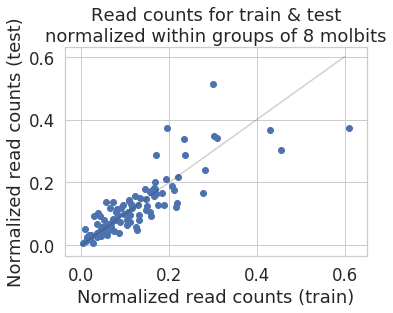

In [15]:
r, p = pearsonr(norm_train_molbit_counts, norm_test_molbit_counts)
fig, ax = plt.subplots(figsize=(5.7, 4.7))
plt.scatter(norm_train_molbit_counts, norm_test_molbit_counts)
plt.plot([0, 0.6], [0, 0.6], c="k", alpha=0.2)
print(f"pearson r = {r}")
print(f"p = {p}")
plt.title("Read counts for train & test\nnormalized within groups of 8 molbits")
plt.xlabel("Normalized read counts (train)")
plt.ylabel("Normalized read counts (test)")
plt.tight_layout()
plt.savefig("../plots/read_counts_train_vs_test.svg")